In [1]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# --- PLOT STYLE ---
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.5,
})

In [2]:
# --- HELPER METHODS ---
def plot_ecdf(data, ax=None, **kwargs):
    """
    Make an ECDF step plot.
    """
    ec = ECDF(data)
    ax = ax or plt.gca()
    ax.step(ec.x, ec.y, where='post', **kwargs)
    ax.set_xlabel('Wait (min)')
    ax.set_ylabel('F_hat(x)')
    return ax
def aic(logL, k):
    """
    Compute Akaike Information Criterion.
    AIC = 2*k- 2*logL
    logL = maximized log-likelihood; k = # free parameters in model.
    Lower AIC-> better tradeoff fit vs complexity (same dataset only!).
    """
    return 2*k- 2*logL
def mean_from_params(dist_name, params):
    """
    Convert SciPy .fit() parameters-> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    NOTE: 'loc' shifts the distribution; 'scale' stretches it.
    """
    if dist_name == "gamma":
        a, loc, scale = params
        # a = shape (k)
        return loc + a*scale
    elif dist_name == "weibull_min":
        c, loc, scale = params
        # Gamma mean = loc + k*theta
        # c = shape
        # Weibull mean uses the gamma function:
        return loc + scale*st.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params
        # s = sigma (log-scale SD); scale = exp(mu)
        # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

In [4]:
# --- LOAD DATA ---
df = pd.read_csv('mbta_wait_times.csv')

# --- SPLIT INTO PRE/POST ---
pre = df.loc[df.period=="PRE", "wait_min"].to_numpy()
post = df.loc[df.period=="POST", "wait_min"].to_numpy()

# --- SUMMARY ---
print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min


**Q1.1.** There were 600 data points before construction and 650 after construction.

**Q1.2.** The mean wait time was 3.85 minutes before construction and 4.84 minutes after.

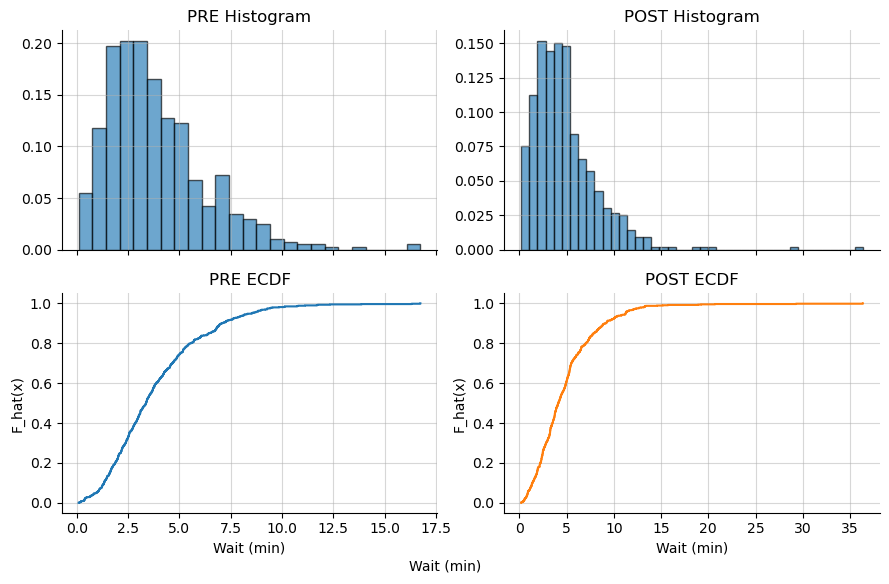

In [6]:
# --- GRID ---
fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex='col')

# TOP ROW: HISTOGRAMS
axs[0,0].hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,1].set_title("POST Histogram")

# BOTTOM ROW: ECDFS
plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")

fig.text(0.5,0.04,"Wait (min)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

**Q2.1.** POST is much more spread out and right-skewed than PRE.

**Q2.2.** PRE appears to have a handful of outliers at around 16-17 minutes. POST has a much smaller outlier rate, but the outliers extend past 35 minutes.

In [13]:
pre_iqr = np.quantile(pre, 0.75) - np.quantile(pre, 0.25)
pre_median = np.quantile(pre, 0.50)
post_iqr = np.quantile(post, 0.75) - np.quantile(post, 0.25)
post_median = np.quantile(post, 0.50)

print(f"----- PRE -----\nIQR: {pre_iqr}\nMED: {pre_median}")
print(f"----- POST -----\nIQR: {post_iqr}\nMED: {post_median}")

pre_outliers = [i for i in pre if (i > (pre_median + 1.5 * pre_iqr) or
                                   i < (pre_median - 1.5 * pre_iqr))]
post_outliers = [i for i in post if (i > (post_median + 1.5 * post_iqr) or
                                     i < (post_median - 1.5 * post_iqr))]


----- PRE -----
IQR: 2.917130087673942
MED: 3.3706277363415857
----- POST -----
IQR: 3.7516647153304827
MED: 4.127242252022315


**Q3.1.**

**Q3.2.** We cannot use a normal distribution because it is impossible to have a negative wait time. Further, the central limit theorem applies when the mean is zero.

In [14]:
# --- MODEL SHORTLIST ---
candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    "lognorm": st.lognorm
}
print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min', 'lognorm']


In [16]:
def fit_models(data, models):
    """
    Fit each SciPy distribution in 'models' to 1-D numpy array 'data'.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better

#--- FIT PRE & POST-------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


**Q4.1.**
- PRE best model: gamma (AIC = 2600.902927)
- POST best model: lognorm (AIC = 3163.261511)

In [20]:
fit_pre['delta_AIC'] = fit_pre['AIC'] - min(fit_pre['AIC'])
fit_post['delta_AIC'] = fit_post['AIC'] - min(fit_post['AIC'])
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC,delta_AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927,0.0
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505,1.730578
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf,inf


POST fits:


,params,logL,k,AIC,delta_AIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511,0.0
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653,0.391489
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013,150.507502


**Q4.2.**

PRE period:
- $\Delta\text{AIC} < 2$: gamma, lognorm
- $4\leq\Delta\text{AIC}\leq 7$: none
- $\Delta\text{AIC} > 10$: weibull

POST period:
- $\Delta\text{AIC} < 2$: gamma, lognorm
- $4\leq\Delta\text{AIC}\leq 7$: none
- $\Delta\text{AIC} > 10$: weibull

In [24]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    """
    Make QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """
    qs = np.quantile(data, probs)
    for name in fit_tbl.index:
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params)
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1)
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

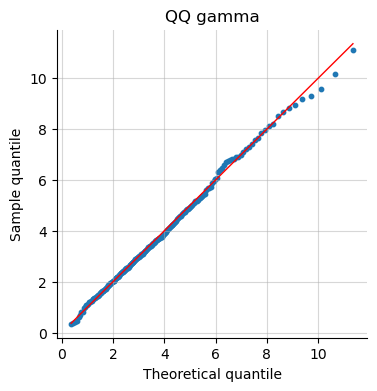

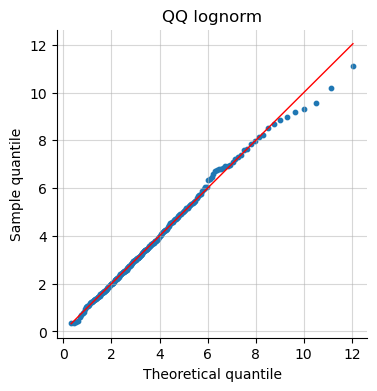

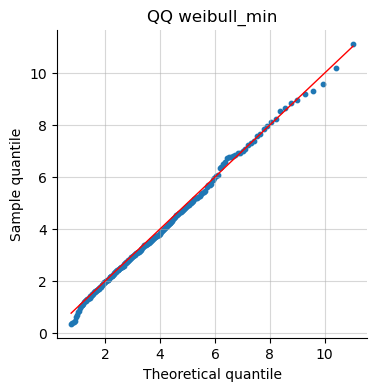

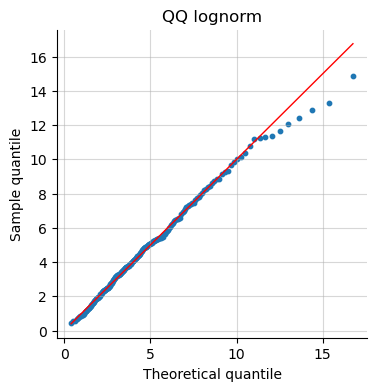

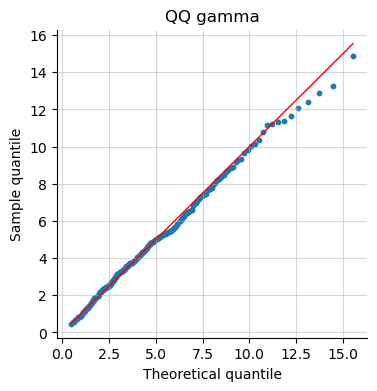

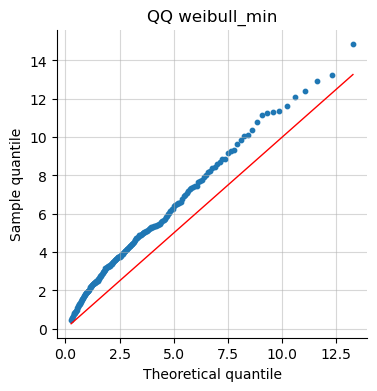

In [25]:
# --- QQ PLOTS ---
qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)

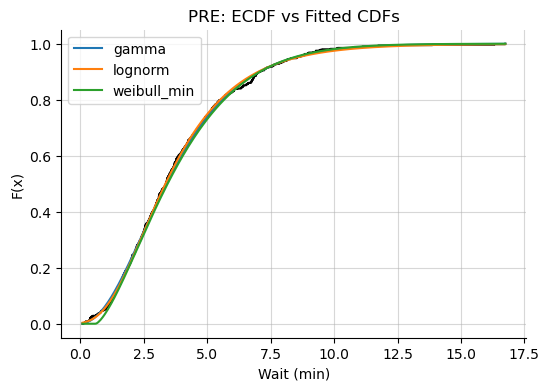

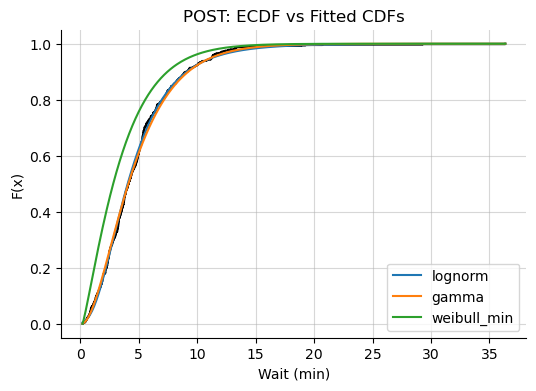

In [27]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model's CDF (smooth lines).
    """
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
    
# --- CDF OVERLAY ---
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

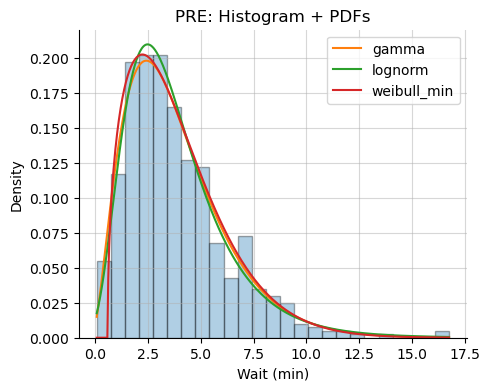

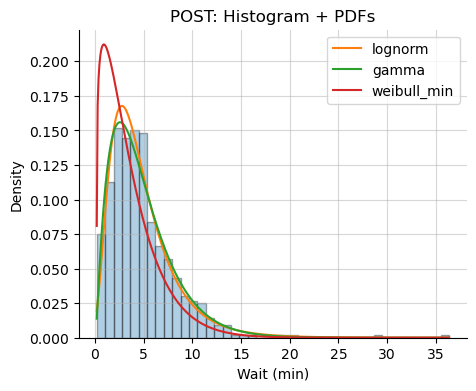

In [29]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (density=True) + PDFs from each fitted model.
    """
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Wait (min)"); plt.ylabel("Density")
    
# --- PDF OVERLAYS ---
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")

**Q5.1.** Models struggle most with the upper tail in the POST period.

**Q5.2.** Out of lognorm, gamma, and weibull, none are particularly stretched by outliers.

In [35]:
# --- PICK BEST MODEL ---
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]

# --- GET MEANS ---
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])

# --- PRACTICAL CHANGE ---
delta = mu_post- mu_pre
ratio = mu_post / mu_pre

print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma mean3.85 min
Best POST model: lognorm mean4.84 min
Change POST-PRE: +0.99 min (1.26)


**Q6.1.** After construction, typical wait times are about 1 minute longer.

**Q6.2.** The difference isn't practically that important, especially since most people won't care if they're spending only one extra minute on average.

**Q6.3.** Yes, because multiple models produce the same conclusion.